In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import LdaModel
import plotly.express as px
import plotly.io as pio
import textwrap
import preamble
import src.constants as const

In [ ]:
# import lda model and data
lda_model = LdaModel.load(const.PATH_MODEL)
df = pd.read_parquet(const.PATH_ALL_SPEECHES)

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [4]:
def print_topics(model, n_topics=const.N_TOPICS, k_words=10):
    '''
    print all n topics of the lda model 
    '''
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics):
        label = ", ".join([word for word, prob in topic[:k_words]])
        print(f"Topic {idx}: {label}")

In [19]:
print_topics(lda_model)

Topic 0: security, united, common, challenge, world, global, strong, future, political, defense
Topic 1: want, think, commissioner, say, know, good, colleague, today, come, talk
Topic 2: budget, fund, financial, euro, billion, million, payment, program, eur, resource
Topic 3: worker, transport, sector, fund, globalization, company, adjustment, industry, market, job
Topic 4: fishing, fishery, sea, water, fish, resource, sustainable, specie, management, vessel
Topic 5: financial, committee, agency, budget, discharge, court, institution, control, auditor, implementation
Topic 6: development, economic, strategy, growth, investment, region, area, sustainable, develop, objective
Topic 7: human, freedom, democracy, political, medium, journalist, government, respect, expression, violation
Topic 8: law, rule, government, democracy, treaty, poland, principle, respect, hungary, party
Topic 9: tax, company, fraud, money, evasion, multinational, financial, transparency, information, pay
Topic 10: w

In [ ]:
# print n most probable speeches for a chosen topic topic_idx
def print_top_speeches(df, model, topic_id, n_speeches=5):
    '''
    Print the n most probable speeches for a given topic id
    '''
    # get topic distribution for each document
    prob_column = "topic_" + str(topic_id)
    top_speeches = df.sort_values(by=prob_column, ascending=False).head(n_speeches)['translatedText']
    
    print(f"\nMost representative speeches for Topic {topic_id}:\n")
    for i, speech in enumerate(top_speeches):
        print(textwrap.fill(speech, width=80))
        print("\n" + "-"*80 + "\n")

In [ ]:
# interpreted topics based on top words and top speeches and identified suitable labels for plotting
topic_labels = [
    "EU Security & Defense", # 0
    "Debate Etiquette & Brexit", # 1
    "EU Finances", # 2
    "Workers and Industry", # 3
    "Fishing", # 4
    "Budgetary Control", # 5
    "Economic Development", # 6
    "Human Rights", # 7
    "Rule of Law", # 8
    "Taxation", # 9
    "Gender Equality", # 10
    "Terrorism & Political Violence", # 11
    "Food Safety", # 12
    "Economic Crisis", # 13
    "Climate & Energy", # 14
    "Trade Relations", # 15
    "International Conflicts", # 16
    "Education and Culture", # 17
    "Intra-European disputes", # 18
    "Migration and Asylum", # 19
    "Legislative Process", # 20
    "Russia–Ukraine", # 21
    "Social Policy & Labor", # 22
    "Data Protection", # 23
    "Agriculture", # 24
    "Election Law", # 25
    "Market Regulation", # 26
    "Natural Disasters & Epidemics", # 27
    "Sanctions & Condemnations", # 28
    "Children’s Rights" # 29
]

In [21]:
topic_list = []
for idx, topic in lda_model.show_topics(formatted=False, num_topics=const.N_TOPICS):
    label = ", ".join([word for word, prob in topic[:3]])
    topic_list.append(label)

In [22]:
# select topic with highest probability for each speech
df['dominant_topic_id'] = df.loc[:, 'topic_0':'topic_29'].idxmax(axis=1).apply(lambda x: int(x.split('_')[1])).astype(int)
# give dominant topic its label
df['dominant_topic'] = df['dominant_topic_id'].apply(lambda x: topic_labels[x])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

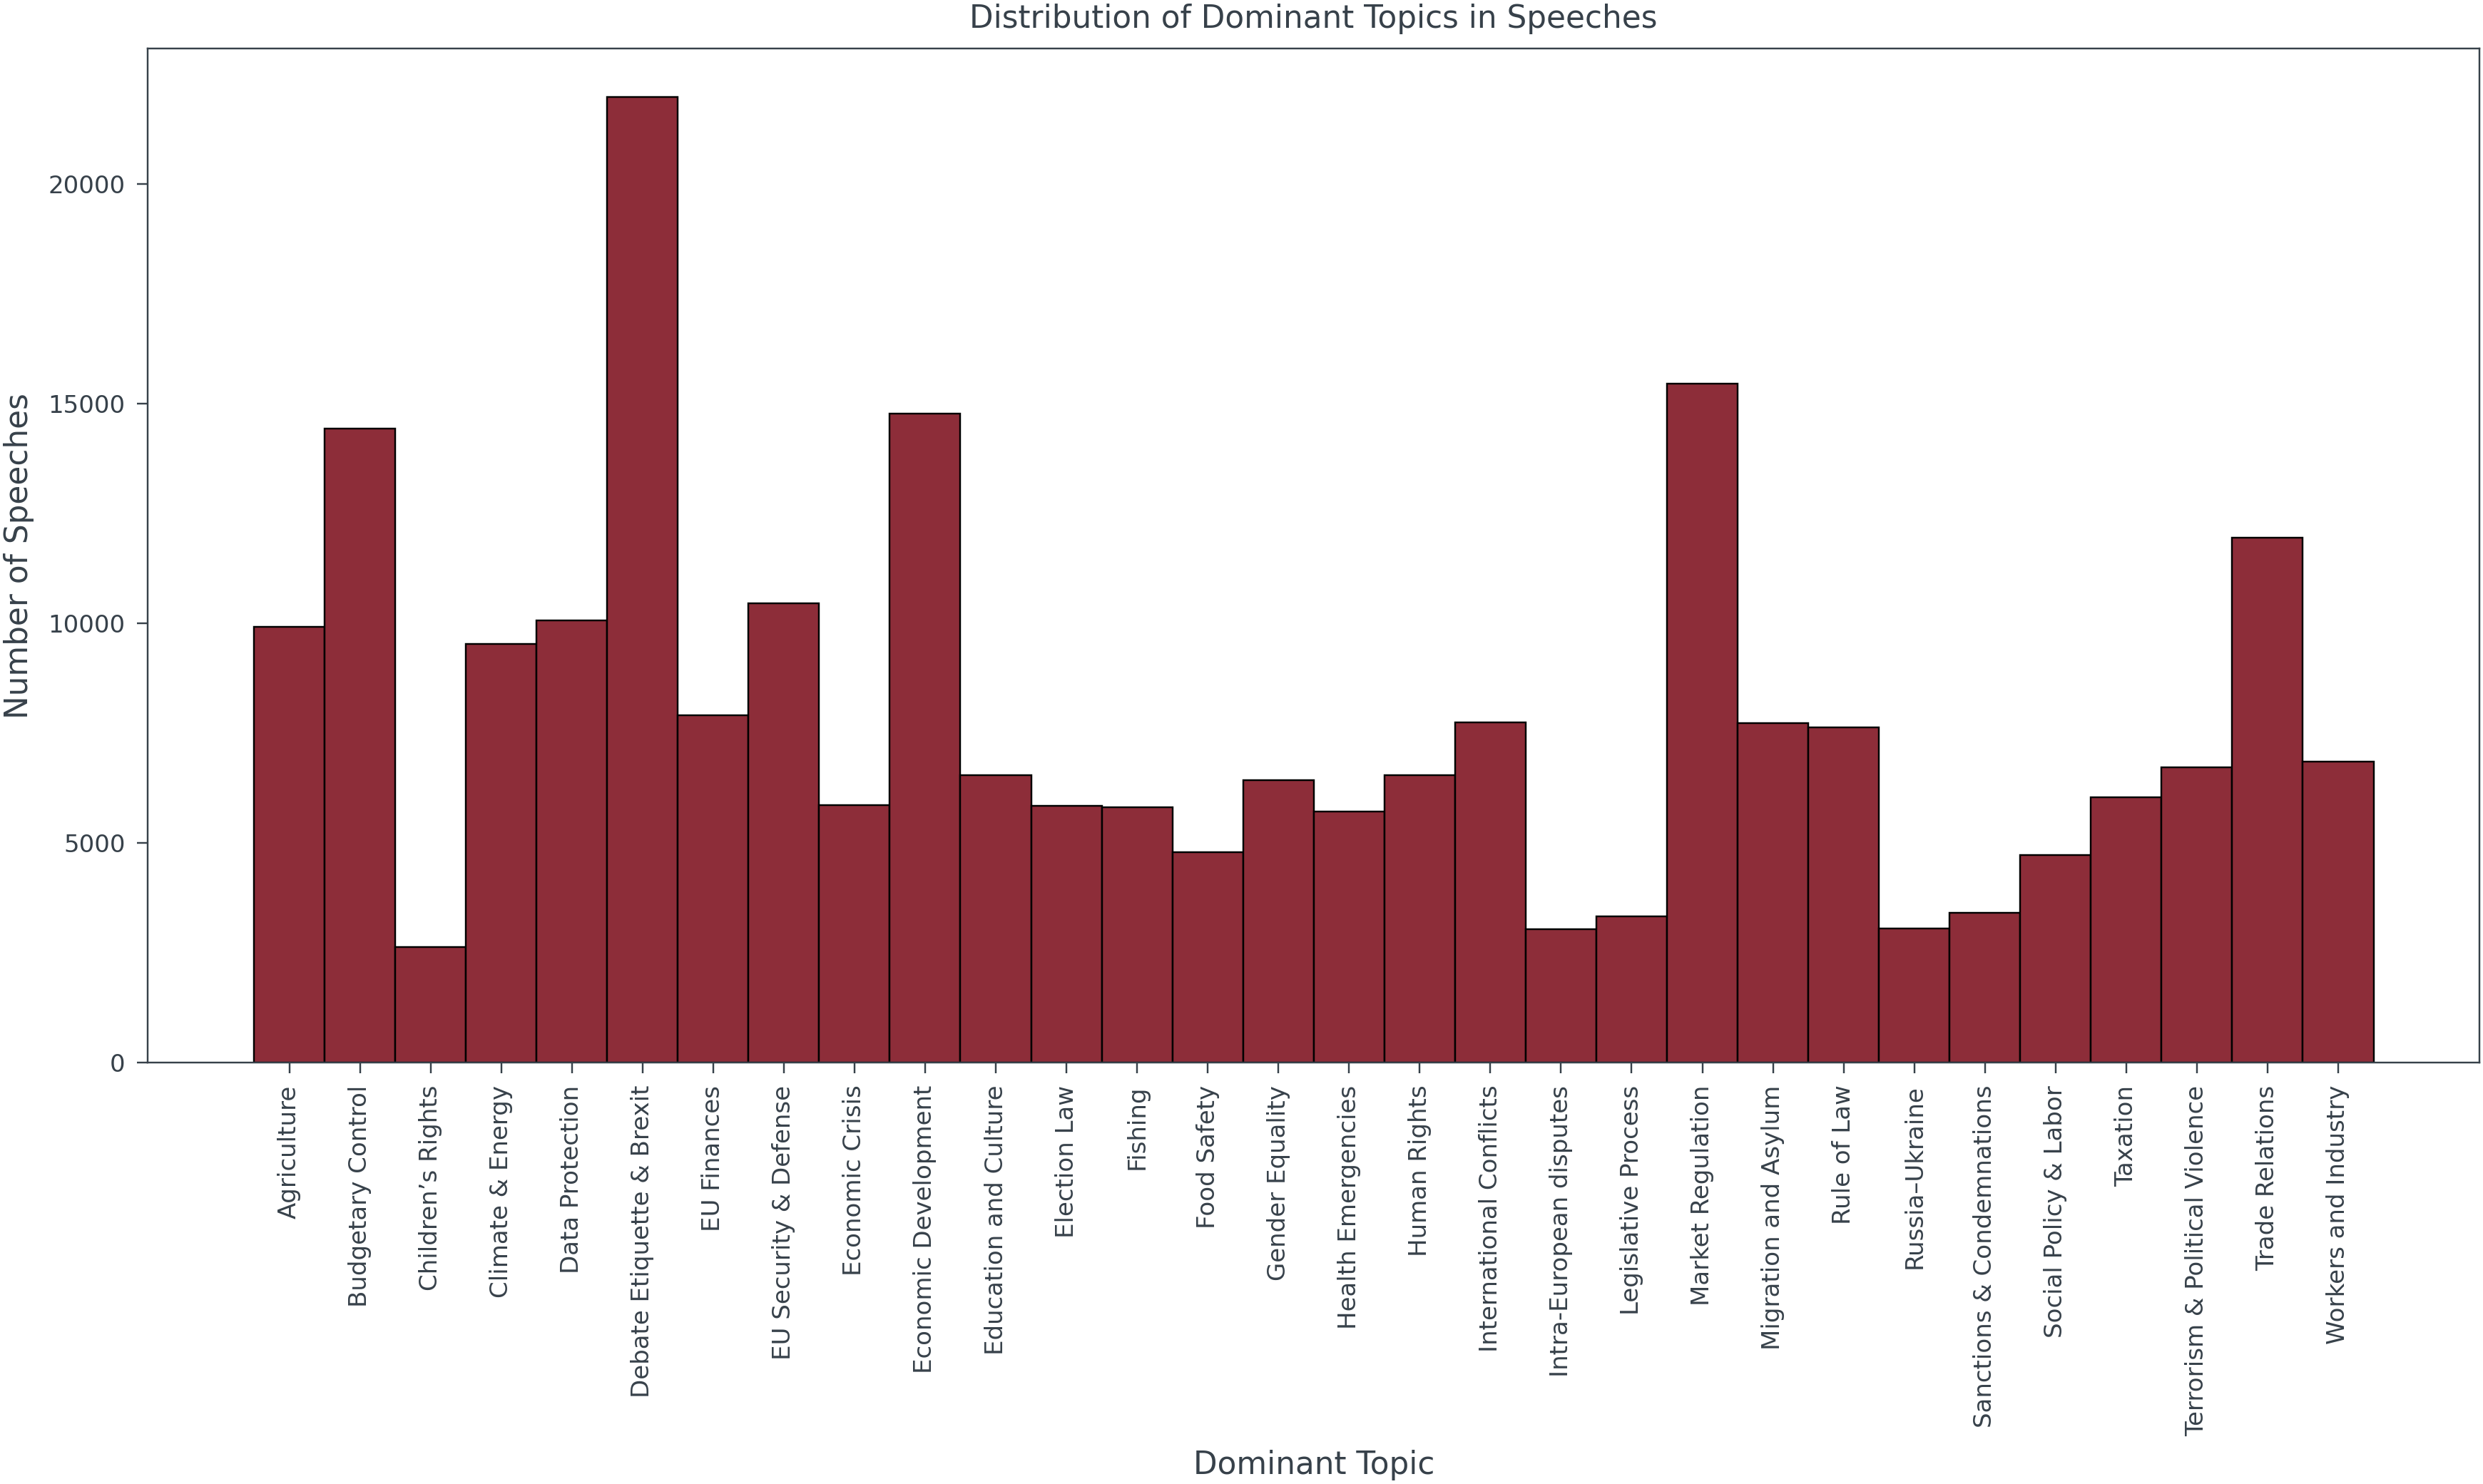

In [23]:
# histogram of dominant topics
plt.figure(figsize=(10,6))
plt.hist(df['dominant_topic'].sort_values(), bins=np.arange(-0.5, 30.5, 1), edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Speeches')
plt.title('Distribution of Dominant Topics in Speeches')
plt.show()

In [25]:
df_dominant = df.groupby(['dominant_topic', 'year']).agg({
    'text': 'count'}).reset_index().rename(columns={'text': 'count'})

# Calculate total speeches per year
year_totals = df_dominant.groupby('year')['count'].sum().reset_index()
year_totals.columns = ['year', 'total_year']

# Merge and calculate ratio
df_dominant = df_dominant.merge(year_totals, on='year')
df_dominant['ratio'] = df_dominant['count'] / df_dominant['total_year']

# add most probable speech for each topic and year to the dataframe
df_dominant['most_probable_speech'] = None
for i, row in df_dominant.iterrows():
    topic = row['dominant_topic']
    year = row['year']
    prob_col = f"topic_{topic_labels.index(topic)}"
    filtered_df = df[(df['year'] == year)]
    top_speech = filtered_df.sort_values(by=prob_col, ascending=False).iloc[0]
    speech_text = top_speech['translatedText'][:500] + "..." if len(top_speech['translatedText']) > 500 else top_speech['translatedText']
    speech_text = "<br>".join(textwrap.wrap(speech_text, width=80))
    df_dominant.at[i, 'most_probable_speech'] = speech_text

# add column with top 5 words for each topic to later inspect on hover
for i in range(const.N_TOPICS):
    topic_terms = lda_model.show_topic(i, topn=5)
    top_words = ", ".join([word for word, prob in topic_terms])
    df_dominant.loc[df_dominant['dominant_topic'] == topic_labels[i], 'top_words'] = top_words

# sort in reverse alphabetical order to line up legend with plot order
df_dominant = df_dominant.sort_values(by='dominant_topic', ascending=False)

In [26]:
# delete original dataframe to save memory
del df

In [27]:
# sanity check: make sure that for each year, the sum of ratios equals 1
check = df_dominant.groupby('year')['ratio'].sum().reset_index()
assert all(np.isclose(check['ratio'], 1.0)), "Ratios do not sum to 1 for all years!"

# sanity check: make sure that for each year, each topic has only one entry
check2 = df_dominant.groupby(['year', 'dominant_topic']).size().reset_index(name='counts')
assert all(check2['counts'] == 1), "There are duplicate entries for some year-topic combinations!"

### Construct Stacked Area Chart

In [ ]:
pio.renderers.default = "browser"
fig = px.area(df_dominant, 
              x='year', 
              y='ratio', 
              color='dominant_topic',
              hover_data={'dominant_topic': True, 
                         'top_words': True, 
                        'ratio': ':.1%',
                         'count': True, 
                         'most_probable_speech': True},
              labels={'dominant_topic': 'Topic', 
                    'top_words': 'Top 5 Keywords', 
                     'year': 'Year', 
                     'ratio': 'Proportion', 
                     'count': 'Number of Speeches', 
                     'most_probable_speech': 'Most Representative Speech'},
              title='Topics Discussed in the European Parliament (2004-2024)',
              subtitle='As identified by LDA Topic Modeling, expressed as proportion of total speeches per year',
              range_y=[0,1]
              )

# Format y-axis as percentage
fig.update_yaxes(tickformat='.0%', title='Proportion of Speeches')

# Customize legend
fig.update_layout(
    legend=dict(
        title=dict(text='Topics', font=dict(size=15, family='Arial')),
        orientation="v",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.02,
        traceorder="reversed",
        font=dict(size=10)
    ),
    title=dict(
        font=dict(size=16, family='Arial'),
        x=0.5,
        xanchor='center'
    ),
    hovermode='closest',
    
)

fig.show()